# Summary
There are two parts to how a movement between point A and point B might vary. The first is variance in the actual movement path taken to get from point A to point B, and the second is the speed of the movement. Here, I'll analyze the movement path variance, `var_p`, across all __Hit__ trials that successfully have movement from the first threshold to the second threshold from 1 day (and ignore variance in speed for now). I will define a `movement` as the recorded lever movement between a defined first and second threshold. I will then plot the variance of this path, `var_p`, over the % movement completion between the first and second threshold. I also calculate the average movement path, `mean_p`, for __Hit__ trials that had movement from the first threshold to the second threshold for this 1 day.

### imports:

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

import pickle # save data
import glob # find files in a directory
import re # regex for string parsing

### set `folder_name` and `day`

In [3]:
folder_name = './Data/AnB1/'
day = 1
lever_data_folder_name = "./Data/AnB1/LeverData_ANB1_d1/"
lever_data_matfile = "./Data/AnB1/LeverData_ANB1_d1.mat"

### sort through relevant .mat files found in folder by day ("_d#")

In [4]:
# for all ToneDisc .mat files in this folder starting with "ToneDisc_" in their name
mat_file = glob.glob(folder_name+'ToneDisc_*d'+str(day)+'.mat')[0]

### extract one day's data from corresponding .mat file

In [5]:
mat_dict = io.loadmat(mat_file)

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### find all movements from trials that meet both thresholds, and store the trial index and arduion indices for these movements in `movements` so we can find them again later

list `movements`: each element is a list about the movement, 3 subelements per movement `trial_i` |  `first_threshold_lever_i` | `second_threshold_lever_i`

In [110]:
# get `respMTX` (trials) and `lever_data` from response
lever_data = response[0]
#print("lever_data shape: "+str(lever_data.shape))
respMTX = response[2]
MVT0 = -1 * respMTX[0, 4]
print("MVT0 for all trials should be the same: ", MVT0)
num_trials = respMTX.shape[0]
print("num trials: ", num_trials)

decision_duration = params[6][0][0][3][0][0]
print("decision duration: ", decision_duration)

mvt_threshold = params[7][0][0][0][0][0] /0.0049 *5 /1023 # uhhh VBP's conversion rate is not exact
print("mvt threshold: ", mvt_threshold, MVT0 + mvt_threshold)
nomvt_threshold = params[7][0][0][1][0][0] /0.0049 *5 /1023 +0.1
print("nomvt threshold: ", nomvt_threshold, MVT0 + nomvt_threshold)

rewarded_trials = 0

movements = []
for trial_i in range(0, num_trials):

    # Read the binary file created by the C++ program which is saved as double
    trial_frequencies = np.fromfile(lever_data_folder_name+"trial_frequencies.bin", dtype=np.double)
    lever_data = np.fromfile(lever_data_folder_name+"processed_trial"+str(trial_i)+".bin", dtype=np.double)
    num_samples = lever_data.shape[0]
    fs = trial_frequencies[trial_i]
    trial_start_time = respMTX[trial_i, 0]
    lever_ts = np.linspace(trial_start_time, trial_start_time + ((1/fs)*num_samples), num=num_samples)

    # only trials where there was a tone
    if ~np.isnan(respMTX[trial_i, 1]):
        # get the row in lever_data for tone_t
        tone_t = respMTX[trial_i, 1]
        for lever_i, lever_t in enumerate(lever_ts):
            if tone_t <= lever_t:
                tone_lever_i = lever_i
                break
        
        # get the row in lever_data for decision_end_t
        decision_end_t = tone_t + decision_duration
        for lever_i, lever_t in enumerate(lever_ts):
            if decision_end_t <= lever_t:
                decision_end_lever_i = lever_i
                break
        
        if respMTX[trial_i, 6] == 1:
            rewarded_trials += 1
            # get the row in lever_data for lever_pressed_t
            lever_pressed_t = respMTX[trial_i, 3]
            for lever_i, lever_t in enumerate(lever_ts):
                if lever_pressed_t <= lever_t:
                    lever_pressed_lever_i = lever_i
                    break
            print("rewarded @ ", lever_data[lever_pressed_lever_i], "V")

            # first threshold
            first_threshold_lever_i = 0
            first_threshold = MVT0 + nomvt_threshold
            # if lever was pressed
            if ~np.isnan(respMTX[trial_i, 3]):
                for lever_i, lever_value in enumerate(lever_data[\
                    tone_lever_i:decision_end_lever_i\
                    ]):
                    if lever_value >= first_threshold:
                        first_threshold_lever_i = lever_i + tone_lever_i
                        break

            # second threshold
            second_threshold_lever_i = 0
            second_threshold = MVT0 + mvt_threshold
            # if lever was pressed
            if ~np.isnan(respMTX[trial_i, 3]):
                for lever_i, lever_value in enumerate(lever_data[\
                    first_threshold_lever_i:decision_end_lever_i\
                    ]):
                    if lever_value >= second_threshold:
                        second_threshold_lever_i = lever_i + first_threshold_lever_i
                        break
            
            # third threshold
            third_threshold_lever_i = 0
            third_threshold = MVT0 + nomvt_threshold
            # if lever was pressed
            if ~np.isnan(respMTX[trial_i, 3]):
                for lever_i, lever_value in enumerate(lever_data[\
                    second_threshold_lever_i:\
                    ]):
                    if lever_value <= third_threshold:
                        third_threshold_lever_i = lever_i + second_threshold_lever_i
                        break

            # if both first threshold and second threshold are met, add to movements
            if (first_threshold_lever_i != 0) and (second_threshold_lever_i !=0) and (third_threshold_lever_i !=0):
                movement_lever_ts = lever_ts[first_threshold_lever_i:third_threshold_lever_i]
                movement_lever_data = lever_data[first_threshold_lever_i:third_threshold_lever_i]
                movements.append([trial_i, movement_lever_ts, movement_lever_data])
            else:
                print("ERROR: rewarded, but not both thresholds for trial ", trial_i)

print("number of rewarded trials: ", rewarded_trials)
print("number of extracted_movements ", len(movements))

MVT0 for all trials should be the same:  2.669568999999999
num trials:  183
decision duration:  5
mvt threshold:  0.17954395834580164 2.849112958345801
nomvt threshold:  0.21969597223053444 2.8892649722305337
rewarded @  3.0500575560109566 V
rewarded @  2.848718974698425 V
ERROR: rewarded, but not both thresholds for trial  1
rewarded @  2.8888499879637983 V
rewarded @  2.8540945204554355 V
rewarded @  2.922151526444701 V
rewarded @  2.8850231665508494 V
rewarded @  2.9029469970163437 V
rewarded @  2.897001883061401 V
rewarded @  2.92230611402721 V
rewarded @  2.8662336335807437 V
rewarded @  2.9444749651683058 V
rewarded @  2.71006258534309 V
rewarded @  2.814881009743594 V
rewarded @  2.910062863496086 V
rewarded @  2.8899683042170814 V
rewarded @  2.9073704725158267 V
rewarded @  2.817387242721768 V
rewarded @  2.798647046888558 V
rewarded @  2.9981915316940775 V
rewarded @  2.9160441605286462 V
rewarded @  2.867777303935577 V
rewarded @  2.9672039494280953 V
rewarded @  2.907806587

check by plotting:

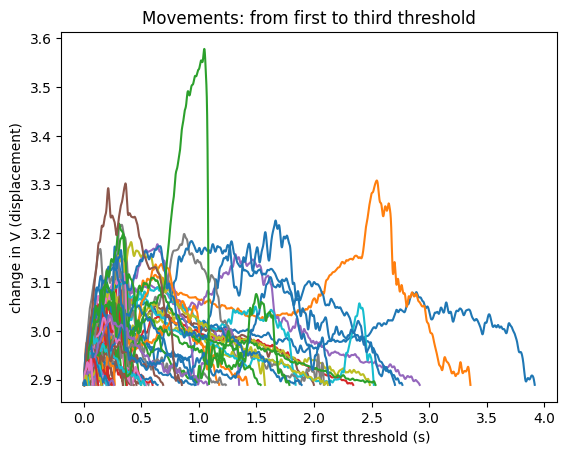

In [111]:
for movement in movements:
    # also check by plotting all of the movements
    plt.plot(\
        movement[1] - movement[1][0],\
        movement[2]\
        )
plt.title("Movements: from first to third threshold")
plt.xlabel("time from hitting first threshold (s)")
plt.ylabel("change in V (displacement)")
plt.xlim()
plt.show()

### Plot the movement paths across % movement completed as the x-axis

Text(0.5, 1.0, 'Movement paths from first to third threshold (1 day)')

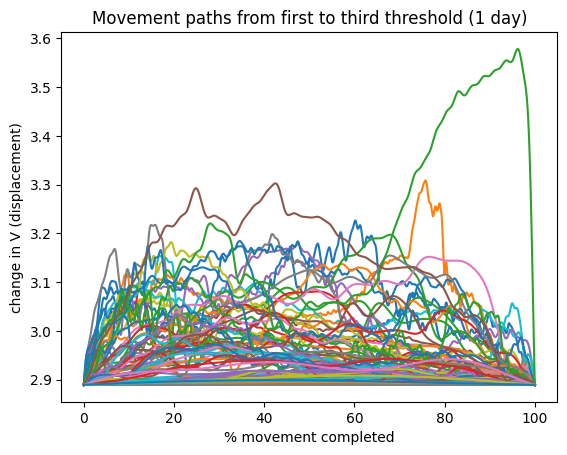

In [113]:
for movement in movements:
    # also check by plotting all of the movements
    plt.plot(\
        (movement[1] - movement[1][0]) *100 /(movement[1][-1] - movement[1][0]),\
        movement[2]\
        )
plt.xlabel("% movement completed")
plt.ylabel("change in V (displacement)")
plt.title("Movement paths from first to third threshold (1 day)")

### calculate the movement path variance, `var_p`, across each `interpolated_movement_dataArduino`

In [31]:
var_p=np.var(interpolated_movements_dataArduino, axis=0)

plot `var_p` across % movement completed

Text(0.5, 1.0, 'Variance of movement paths from first to second threshold for this day')

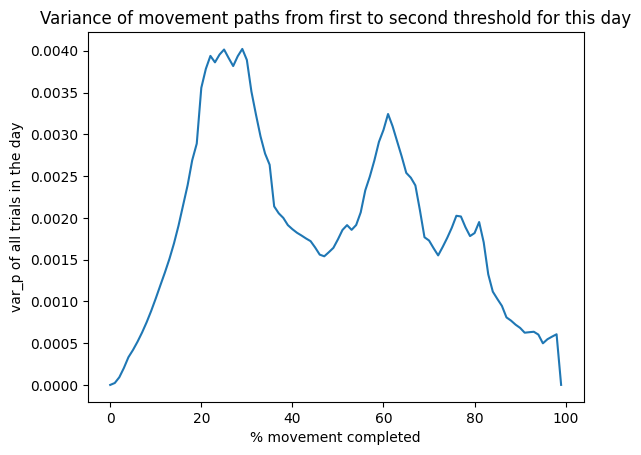

In [32]:
plt.plot(range(0,100), var_p)
plt.xlabel("% movement completed")
plt.ylabel("var_p of all trials in the day")
plt.title("Variance of movement paths from first to second threshold for this day")

### Also calculate the average movement path, `mean_ps`, across each `interpolated_movement_dataArduino`

In [33]:
mean_p=np.mean(interpolated_movements_dataArduino, axis=0)

plot `mean_p` across % movement completed

Text(0.5, 1.0, 'Mean movement path from first to second threshold for this day')

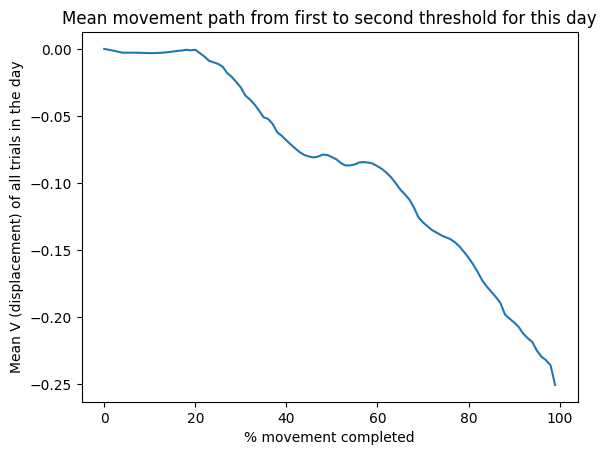

In [34]:
plt.plot(range(0,100), mean_p)
plt.xlabel("% movement completed")
plt.ylabel("Mean V (displacement) of all trials in the day")
plt.title("Mean movement path from first to second threshold for this day")

### save `movements_dataArduino`, `interpolated_movements_dataArduino`, and `movements_var_ps` in the same folder

In [35]:
file = open(mat_file_string+'_interpolated_times_dataArduino.pickle', 'wb')
pickle.dump(interpolated_times_dataArduino, file)
file.close()

file = open(mat_file_string+'_interpolated_movements_dataArduino.pickle', 'wb')
pickle.dump(interpolated_movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_movements_dataArduino.pickle', 'wb')
pickle.dump(movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_var_p.pickle', 'wb')
pickle.dump(var_p, file)
file.close()

file = open(mat_file_string+'_mean_p.pickle', 'wb')
pickle.dump(mean_p, file)
file.close()